In [ ]:
pip install tensorflow-addons

In [ ]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.datasets.mnist as mnist
from keras import backend as K
import tensorflow_addons as tfa
import time as time

Import les donées

In [ ]:
(train_image, train_labels), (test_image, test_labels) = tf.keras.datasets.mnist.load_data()
#train_image.shape = (60000, 28, 28), train_labels.shape = (60000,)

Traitement les données

In [ ]:
# Normalisation les données 0 - 255 en -1 - 1
train_image = (train_image - 127.5)/127.5 # 把0-255的数据范围变为-1到1之间
test_image = (test_image - 127.5)/127.5 # 把0-255的数据范围变为-1到1之间

# Augmenter la dimension du canal 增加通道维度
#train_image = tf.expand_dims(train_image, -1)
#test_image = tf.expand_dims(test_image, -1)
#train_image.shape = ([60000, 28, 28, 1]), train_labels.shape = (60000,)

# Transformation de type 类型转换
train_image = tf.cast(train_image, tf.float32)
test_image = tf.cast(test_image, tf.float32)
train_labels = tf.cast(train_labels, tf.int64)
test_labels = tf.cast(test_labels, tf.int64)

Créer un jeu de données 创建数据集

In [ ]:
# 创建Dataset
batchsize = 256
dataset = tf.data.Dataset.from_tensor_slices((train_image, train_labels)).shuffle(60000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)


## Construire le modèle MLP et l'entraîner 

In [ ]:
from keras import backend as K
def l1_reg(weight_matrix, epsilon):
    return epsilon * tf.math.reduce_sum(tf.math.abs(weight_matrix))

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss_with_FGSM(model, input_image, input_label, epsilon):
    with tf.GradientTape() as tape:
      tape.watch(input_image)
      prediction = model(input_image)
      loss = loss_object(input_label, prediction)
    loss_adv = l1_reg(model.trainable_weights, epsilon)  
    return loss - loss_adv



In [ ]:
from keras import regularizers
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    #tf.keras.layers.Dense(128, activation='sigmoid', name='dense_1'),
    #tf.keras.layers.Dense(64, activation='sigmoid', name='dense_2'),
    tf.keras.layers.Dense(10, activation='sigmoid', name='dense_3' )
])
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_33 (Flatten)        (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='sgd',loss=loss_func,metrics=['acc'])
#history = model.fit(dataset, validation_data = test_dataset, epochs=10) # 返回字典类型的数据 其中记录了准确率和损失的信息

In [ ]:
def training_loop(model, epochs, optimizer, learning_rate, loss_fn, train_set, val_images, val_labels, nombre_example=60000, batchsize=128):
	optimizer.lr = learning_rate
	acc_collect = []
	loss_collect = []
	len = int(np.floor(nombre_example / batchsize))

	for epoch in range(epochs):
		start_epoch = time.time()
		step = 0
		for element in train_set:
			step = step+1
			start_step = time.time()
			images  = element[0]
			labels = element[1] 
			with tf.GradientTape() as tape:
				loss_value = loss_with_FGSM(model, images, labels, epsilon=0.01)
			grads = tape.gradient(loss_value, model.trainable_weights)
			optimizer.apply_gradients(zip(grads, model.trainable_weights))
			if step == len-1:
				logits_val = model(val_images)
				logits_val = np.argmax(logits_val, axis=-1)
				m = tf.keras.metrics.Accuracy()
				m.update_state(val_labels, logits_val)
				acc_collect.append(m.result().numpy())
				print('epoch = ',epoch,'acc train fin epoch = ',m.result().numpy())
				loss_value_temp = loss_value._copy()
				loss_value_temp = float(loss_value_temp)
				loss_collect.append(loss_value_temp)
				print('loss fin epoch = ',loss_value_temp)
	print()
	return model

In [ ]:
model = training_loop(model, epochs=10, optimizer=optimizer, learning_rate=0.001, loss_fn=loss_func, train_set=dataset, val_images=test_image, val_labels=test_labels, nombre_example=60000, batchsize=128)

InvalidArgumentError: ignored

##Implémenter FGSM(Fast Gradient Sign Method)
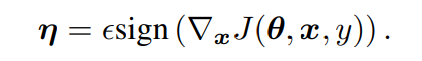

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
perturbations = create_adversarial_pattern(test_image, test_labels)

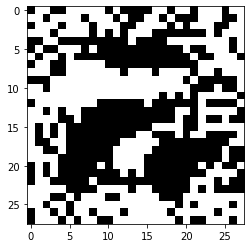

In [ ]:
#check la première perturbation
plt.imshow(perturbations[0],cmap='gray_r')#image en niveaux de gris

Définir une fonction pour plot les images

In [ ]:
# image: Ensemble d'images originales
# label: Ensemble d'étiquette true par le modèle d'image d'origine
# adv_lable: Ensemble d'étiquette prédite par le modèle après l'ajout de la perturbation
# num: Le nombre d'image d'afficher
def display_images(image, label,adv_label, num = 10):
  fig = plt.figure(figsize=(2*num,3))  
  for i in range(num):  
      plt.subplot(1,num,i+1)
      plt.imshow(image[i,:,:],cmap='gray') # + 1)/2) 
      plt.title('{} -> {}'.format(label[i],adv_label[i]))
      plt.axis('off') 
  plt.show()


##Ajouter la perturbations et Tester dans le jeu de test

epsilons = 0:
313/313 [==============================] - 0s 830us/step


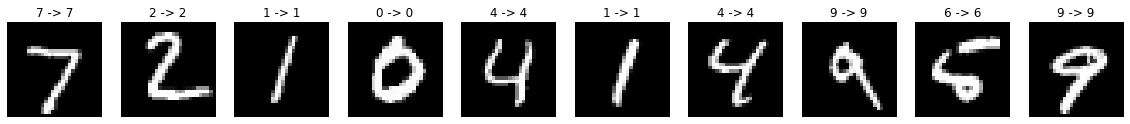

epsilons = 0.05:
313/313 [==============================] - 0s 843us/step


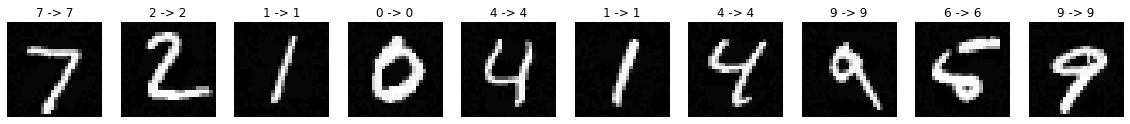

epsilons = 0.1:
313/313 [==============================] - 0s 803us/step


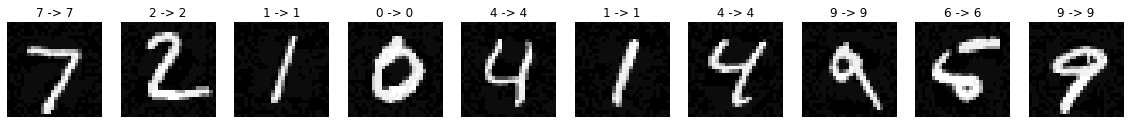

epsilons = 0.15:
313/313 [==============================] - 0s 835us/step


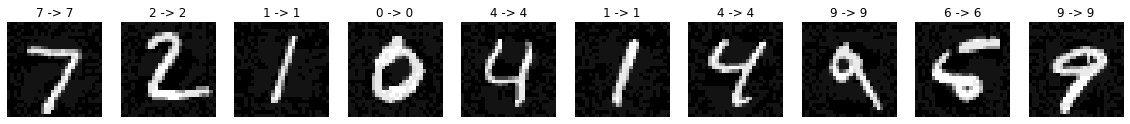

epsilons = 0.2:
313/313 [==============================] - 0s 765us/step


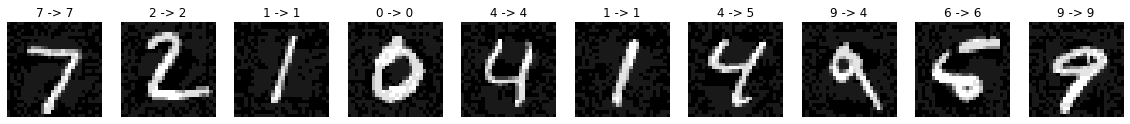

epsilons = 0.25:
313/313 [==============================] - 0s 857us/step


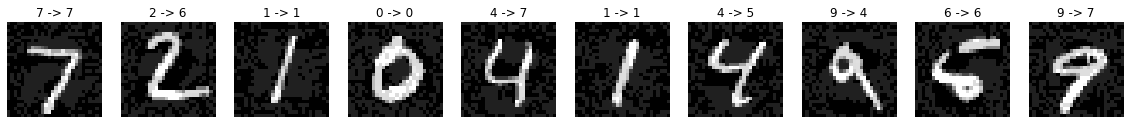

epsilons = 0.3:
313/313 [==============================] - 0s 793us/step


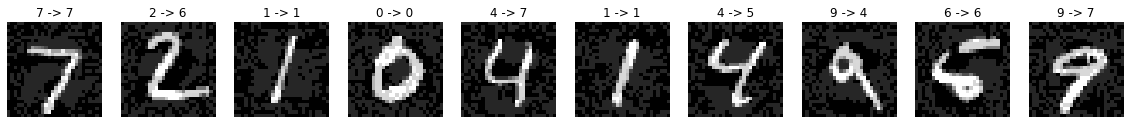

In [ ]:
# Tester dans les différentes valeurs d'epsilon 
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Obtenir le résultat de la prédiction de l'image d'origine 
  test_image = tf.clip_by_value(test_image, -1, 1)
  predict_label = model.predict(test_image)
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 
  adv_image = test_image + eps*perturbations
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  adv_predict_label = model.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 
  score = model.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)

## L’entraînement contradictoire 对抗训练



In [ ]:
perturb = create_adversarial_pattern(train_image, train_labels)
train_adv = train_image+0.3*perturb
train_train_adv = tf.concat([train_image, train_adv], 0) #对抗训练集 = 原训练集+加了扰动的训练集 （120000 images） 
print(np.shape(train_train_adv))
labels_label_adv = tf.concat([train_labels, train_labels], 0)  #labels = 2*原labels，因为加了扰动的图像还属于该标签

(120000, 28, 28)


In [ ]:
dataset_adv = tf.data.Dataset.from_tensor_slices((train_train_adv, labels_label_adv)).shuffle(120000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)

In [ ]:
model_adv = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])
optimizer_adv = tf.keras.optimizers.Adam()
loss_func_adv = tf.keras.losses.SparseCategoricalCrossentropy()
model_adv.compile(optimizer=optimizer,loss=loss_func_adv,metrics=['acc'])
history = model_adv.fit(dataset_adv,validation_data=test_dataset,epochs=10)

Epoch 1/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3425 - acc: 0.8969 - val_loss: 0.2585 - val_acc: 0.9228
Epoch 2/10
469/469 [==============================] - 4s 7ms/step - loss: 0.1465 - acc: 0.9574 - val_loss: 0.1907 - val_acc: 0.9450
Epoch 3/10
469/469 [==============================] - 4s 7ms/step - loss: 0.1093 - acc: 0.9681 - val_loss: 0.1630 - val_acc: 0.9517
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0891 - acc: 0.9732 - val_loss: 0.1585 - val_acc: 0.9521
Epoch 5/10
469/469 [==============================] - 4s 7ms/step - loss: 0.0769 - acc: 0.9768 - val_loss: 0.1290 - val_acc: 0.9625
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0683 - acc: 0.9796 - val_loss: 0.1316 - val_acc: 0.9615
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0610 - acc: 0.9812 - val_loss: 0.1105 - val_acc: 0.9653
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 0

epsilons = 0:
313/313 [==============================] - 1s 2ms/step


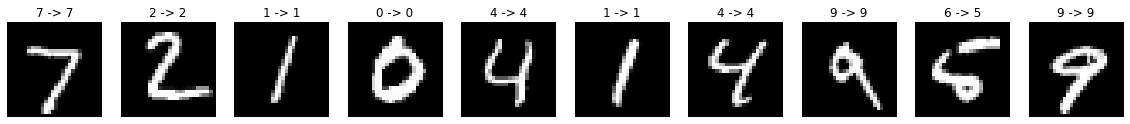

epsilons = 0.05:
313/313 [==============================] - 1s 2ms/step


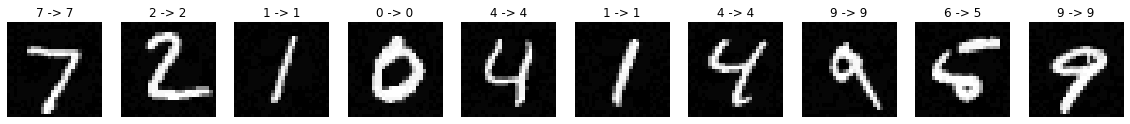

epsilons = 0.1:
313/313 [==============================] - 1s 2ms/step


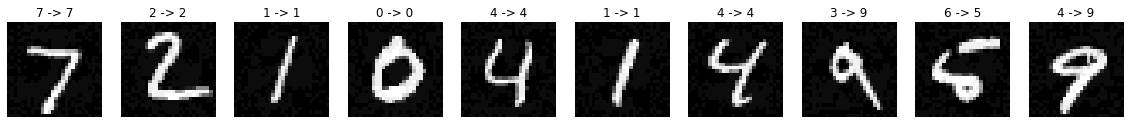

epsilons = 0.15:
313/313 [==============================] - 1s 3ms/step


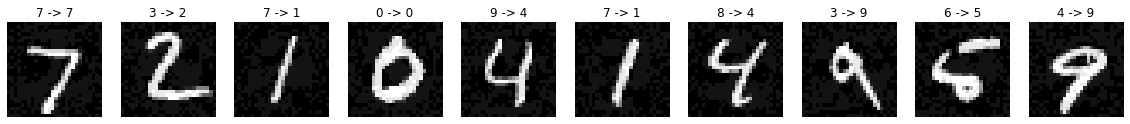

epsilons = 0.2:
313/313 [==============================] - 1s 2ms/step


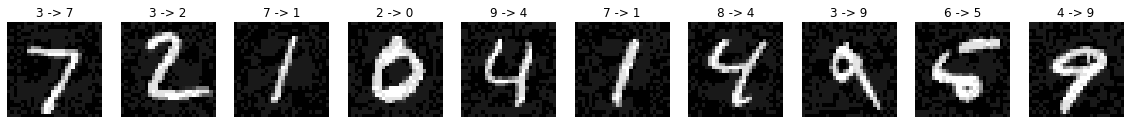

epsilons = 0.25:
313/313 [==============================] - 1s 3ms/step


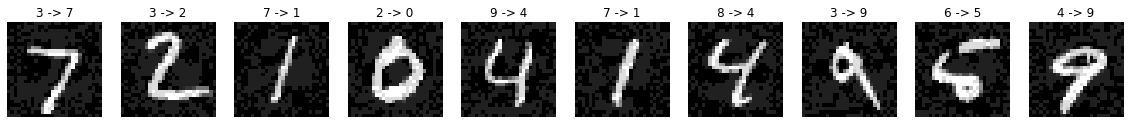

epsilons = 0.3:
313/313 [==============================] - 1s 3ms/step


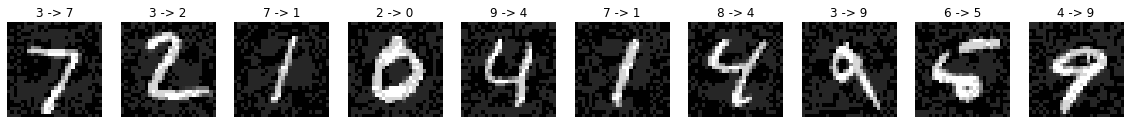

In [ ]:
# Tester dans les différentes valeurs d'epsilon 在不同的epsilons进行测试
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  adv_image = test_image + eps*perturbations      # 对抗样本测试集=测试集加上干扰
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  # Obtenir le résultat de la prédiction de l'image d'origine 获取原始图片的预测结果
  #test_image = tf.clip_by_value(adv_image, -1, 1)
  predict_label = model.predict(adv_image) 
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 生成对抗样本，并获取预测结果
  adv_predict_label = model_adv.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 在对抗样本集合中评估模型
  score1 = model.evaluate(adv_image,test_labels,verbose=0)
  acc_list.append(score1[1])
  score = model_adv.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)

  ## 输出标签：原模型对对抗样例的预测 -> 用对抗训练的模型对对抗样例的预测

Afficher la précision en fonction d'epsilons

NameError: ignored

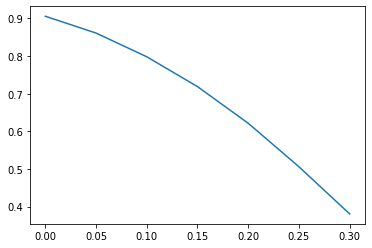

In [ ]:
plt.figure()
plt.plot(epsilons,adv_acc_list,label='acc_model_adv')
plt.plot(epsilons,acc_list,label='acc_model')
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.legend()
plt.grid()
plt.show()
print('acc',adv_acc_list)
print('epsilons',epsilons)

In [ ]:
# 